# Performing single-cell velocity analysis with scVelo
### Group 4: Shreyas Labhsetwar, Daniel Sabater Minarim, Kevin Li

# Background

Single-cell RNA sequencing (scRNA-seq) analysis is pivotal for understanding cellular dynamics, such as differentiation and development. RNA velocity, a technique used to assess the ratio of unspliced to spliced RNA, offers insights into future cell states. This tutorial introduces tools like Cell Ranger, Loupe Browser, velocyto, and scVelo, essential for RNA velocity analysis, using a dataset of over 68,000 peripheral blood mononuclear cells (PBMCs). The cell ranger will help convert the FASTQ into a structured format of a loup, which will help identify cell clusters and generate the UMAP (Uniform Manifold Approximation and Projection - used to visualize high dimensional data into lower dimensional space). The velocyto will then create the .loom file capturing RNA dyamics which will be analyzed by by scVelo.

The aim is to guide participants through most of the process, by briefly going over how the raw data is processed with Cell Ranger to actually analyzing the .loom files with scVelo, providing practical skills relevant to RNA velocity research. By the end, participants will learn to interpret dynamic gene expression changes, applying these methods to future datasets.

By applying RNA velocity analysis to the PBMC data, we will unravel the dynamic interplay among immune cells, finding states of activation, differentiation, and interaction within the immune response. This will show how cells transition inbetween states while responding to an infection or inflammation. Understanding immune regulation within the heterogenous PBMCS populations is crucial for advancing immunotherapies and understanding autoimmune diseases.

# Tutorial

If you haven't done so already, please download `scVelo`, `pandas`, and `python-igraph` first! You can either download the packages in Colab by running the commands below or running `pip` in a terminal and importing the packages into a Jupyter notebook on your local machine.

In [ ]:
!pip install -U scvelo --quiet
!pip install pandas --quiet
!pip install python-igraph --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.6/209.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 29.5 MB/s

## What we *won't* be doing today...

Since we are using a dataset provided by *scVelo*, we are essentially skipping over some steps normally associated with creating our input files for the package. One common way to perform velocity analysis would start with using 10X Genomics' `cellranger` pipeline to process your single-cell experiment files, which generates, among other output files, a filtered feature-barcode matrix (which will be used later) and a `.cloupe` file. This file is used with the Loupe Browser, which can visualize clusters based on UMAP projections and export both of these results.

The *cellranger* output is then used as input for the `velocyto` pipeline along with a `gtf` reference file (which details genomic information on the organism your data comes from). After inputting both of these files, `velocyto` outputs a `.loom` file consisting of spliced and unspliced transcript data that can be used by `scVelo` for velocity analysis. The annotated data from the `.loom` file is then combined with the filtered feature-barcode matrix into 1 object for use in `scVelo`.

However, we will not be doing these steps mostly because of the amount of time `velocyto` can take -- we do not have time to wait for our `.loom` file to be generated in 2 days!

## What we *will* be doing today...

First, let's import `scVelo`. We can also run some commands to create clearer graphs and show the inner workings of each line of code.

In [ ]:
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
def pp(adata):
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.umap(adata)
    return adata

These next few steps relate to how we can pre-process our data for `scVelo`. For instance, `scv.pp.filter_and_normalize` essentially runs 4 functions:

- `scv.pp.filter_genes`
    - Filters genes based on provided cells/counts thresholds
- `scv.pp.normalize_per_cell`
    - Normalizes total counts per cell so that all cells have the same count while keeping identical proportions
- `scv.pp.filter_genes_dispersion`
    - Extracts highly variable genes
- `scv.pp.log1p`
    - Logarithmizes the data matrix

In short, we run `scv.pp.filter_and_normalize` to filter out datapoints that might be outliers and normalize our data to further limit the amount of influential points. We then run `scv.pp.moments`, which calculates the means (first-order moment) and variances (second-order moments) of data points based on a neighbor graph determined from distances via PCA space. We can use these moments to help us calculate the velocities in future steps.

Filtering our dataset of outliers gives us 30k+ datapoints to work with, which is still a large amount of data! Therefore, it might be better to calculate the UMAP embeddings for our dataset by running`scv.tl.umap`. This would replace the PCA calculations by focusing on the amount of neighboring points at a specific distance, creating more defined clusters and preserving the local structure of our dataset more accurately.

In [ ]:
adata = pp(scv.datasets.pbmc68k())

  0%|          | 0.00/118M [00:00<?, ?B/s]

Filtered out 33338 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/usr/local/lib/python3.10/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


computing neighbors
    finished (0:01:25) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


To perform a sanity check, we can calculate the proportions the spliced transcripts to unspliced transcripts. The developers for `scVelo` mention that 10-25% of your data should be unspliced after running your dataset through `velocyto`.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


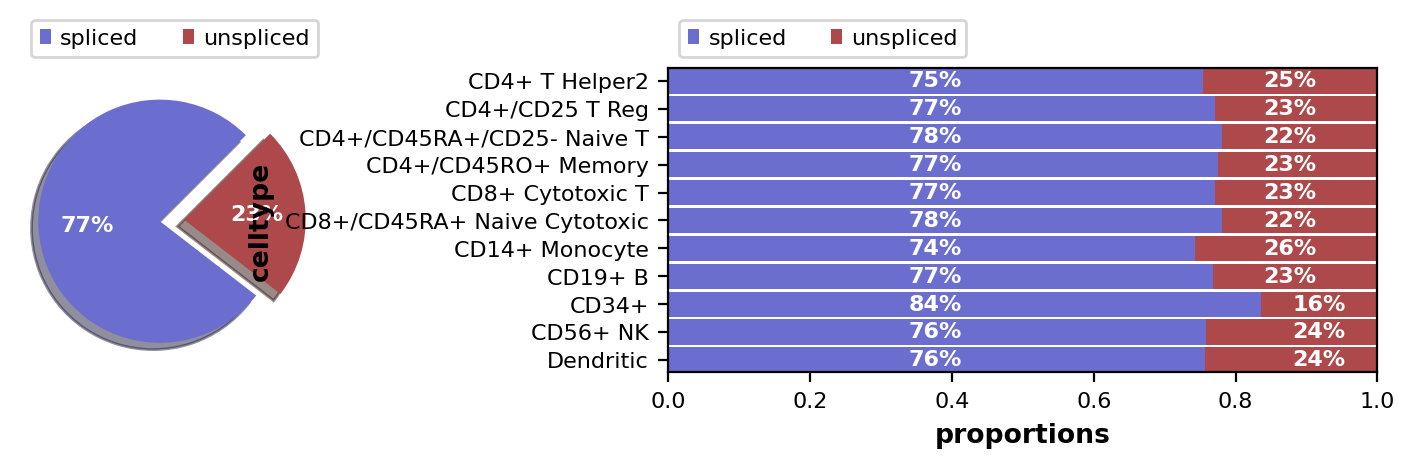

In [ ]:
scv.pl.proportions(adata, groupby='celltype')

Let's take a look at our `adata` object. We can each that each row has a unique cell barcode with their own data across 5 columns:

- `celltype`
    - All immune cells due to dataset type
- `initial_size_unspliced`:
    - Amount of unspliced transcripts within a cell
- `initial_size_spliced`:
    - Amount of spliced transcripts within a cell
- `initial_size`:
    - Initial amount of total RNA molecules within a cell
- `n_counts`:
    - `initial_size` normalized by amount of sequencing reads

In [ ]:
adata.obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,celltype,initial_size_unspliced,initial_size_spliced,initial_size,n_counts
AAACATACACCCAA,CD8+ Cytotoxic T,41,166,166.0,105.512039
AAACATACCCCTCA,CD8+/CD45RA+ Naive Cytotoxic,47,169,169.0,111.893494
AAACATACCGGAGA,CD4+/CD45RO+ Memory,39,141,141.0,115.425514
AAACATACTAACCG,CD19+ B,20,71,71.0,106.971825
AAACATACTCTTCA,CD4+/CD25 T Reg,49,163,163.0,111.257668
...,...,...,...,...,...
TTTGCATGAGCCTA,CD8+ Cytotoxic T,46,145,145.0,106.896553
TTTGCATGCTAGCA,CD8+/CD45RA+ Naive Cytotoxic,34,109,109.0,109.495430
TTTGCATGCTGCAA,CD8+ Cytotoxic T,45,143,143.0,102.972023
TTTGCATGGCTCCT,CD8+ Cytotoxic T,55,132,132.0,111.553017


Now we can calculate the velocities for each datapoint! The default method for doing so comes from the steady-state model, which uses the moments calculated by `scv.pp.moments` to create a linear regression whose coefficient would represent an equilibrium ratio of unspliced to spliced transcripts. Velocities are then calculated as deviations from this equilibrium ratio and converted into vectors. Finally, the transition probabilities are calculated using cosine similarity, in which the neighbor graph from `scv.pp.moments` is used to try finding a neighbor vector that results in a cosine as close to 1 as possible.

`scVelo` performs the velocity calculations by running `scv.tl.velocity` and performs cosine similarity onto a matrix via `scv.tl.velocity_graph`. Afterwards, we can run `scv.pl.velocity_embedding_stream` to plot our velocities onto a UMAP embedding.

In [ ]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing velocities


/usr/local/lib/python3.10/dist-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:01:55) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    finished (0:00:24) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


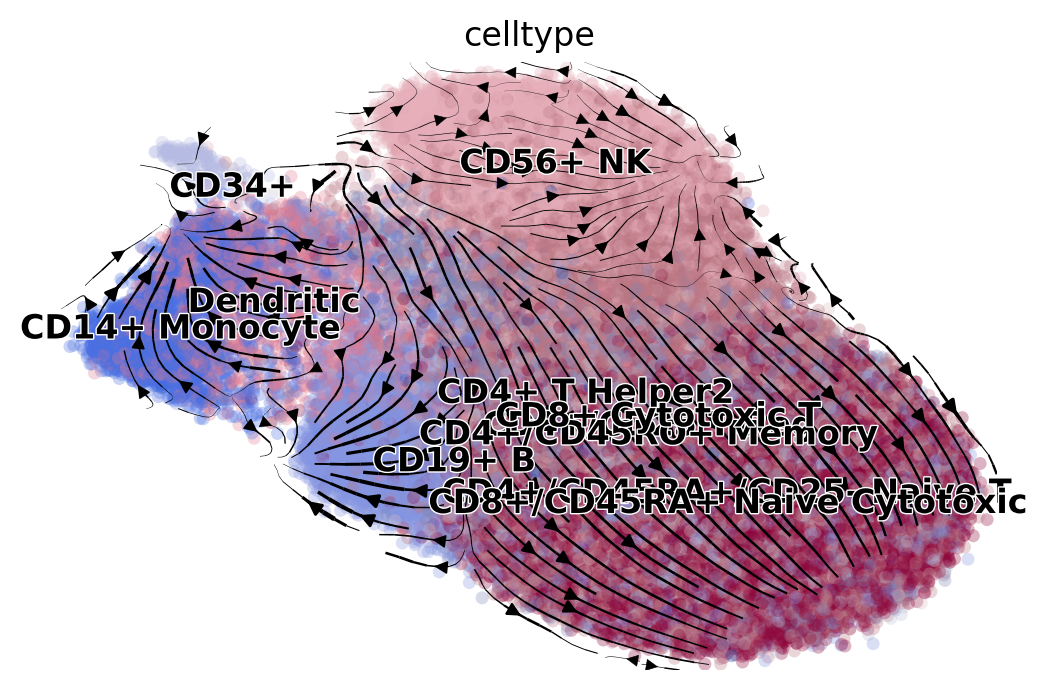

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color="celltype")

What does this plot mean to you?

By the looks of it, a lot of our cells start out as CD56+ NK cells and eventually differentiate towards other types of immune cells, like dendritic cells or CD34+ monocytes. We can also determine that there is a clear split in the differentiation process for CD19+ B cells and CD8+/CD45RA+ naive cytotoxic cells, indicating different patterns of gene expression in these two celltypes. However, just this plot isn't enough to conclude our velocity analysis. We could look further into the genes that make up our data and visualize more clearly the relationships between two clusters, as seen in the next couple analyses.

### Explore Gene Dynamics

1.   [This](https://user-images.githubusercontent.com/31883718/80227452-eb822480-864d-11ea-9399-56886c5e2785.gif) GIF demonstrates the relation between unspliced-spliced reads and gene expression trajectory
2.   Transcriptional induction for a particular gene (i.e. activation of a gene) results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs.
3. Spliced mRNA is produced from unspliced mRNA and follows the same trend with a time lag.
4. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


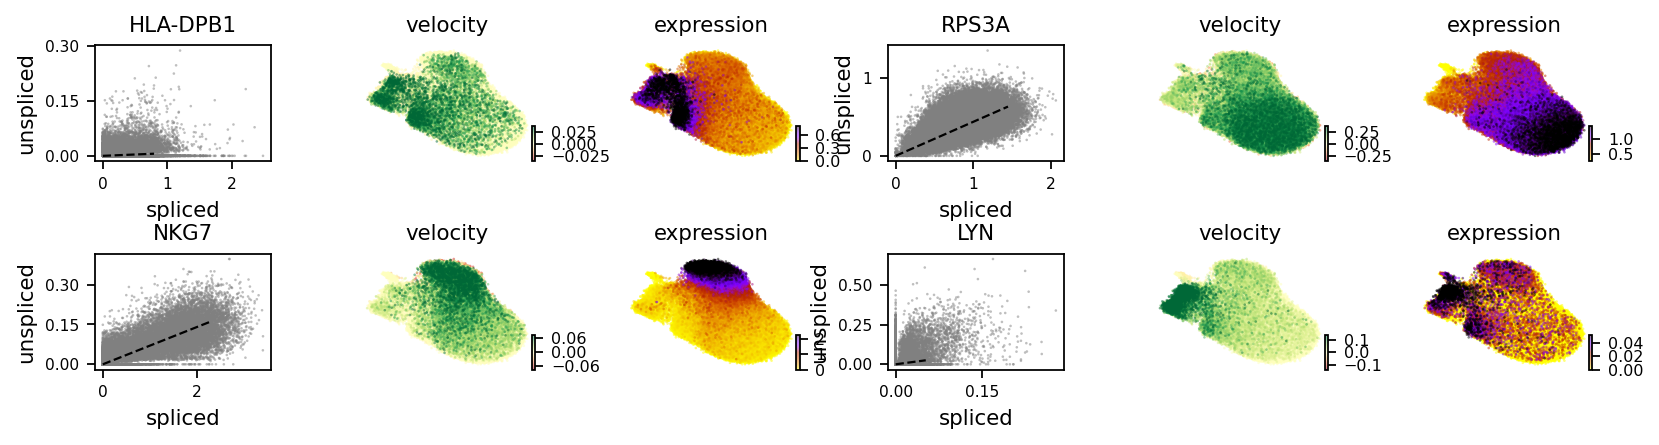

In [ ]:
scv.pl.velocity(adata, ['HLA-DPB1',  'RPS3A', 'NKG7', 'LYN'], ncols=2)

### Identify important genes

To identify genes that may help explain the resulting vector field and inferred lineages, we can test which genes have cluster-specific differential velocity expression - being siginificantly higher/lower compared to the remaining population. The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [ ]:
import pandas as pd

scv.tl.rank_velocity_genes(adata, groupby='celltype', min_corr=.3)

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ranking velocity genes


/usr/local/lib/python3.10/dist-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:13) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,CD4+ T Helper2,CD4+/CD25 T Reg,CD4+/CD45RA+/CD25- Naive T,CD4+/CD45RO+ Memory,CD8+ Cytotoxic T,CD8+/CD45RA+ Naive Cytotoxic,CD14+ Monocyte,CD19+ B,CD34+,CD56+ NK,Dendritic
0,HLA-DPB1,RPS3A,RPS3A,RPS3A,NKG7,RPS3A,LYN,BANK1,HCK,TTC38,LYN
1,IGHD,NKG7,NKG7,NKG7,RPS3A,GZMB,FCN1,HLA-DQA1,AIF1,CCL3,FCN1
2,CD74,GNLY,IGHM,IGHM,GNLY,NKG7,HCK,LINC00926,FCN1,KLRD1,LST1
3,IGHM,GZMB,HLA-DRA,GNLY,GZMB,TYROBP,LST1,HLA-DPB1,CD74,TYROBP,HCK
4,LYN,IGHM,GZMB,GZMB,KLRD1,AIF1,CD74,IGHD,LINC00926,GZMB,HLA-DQA1


In [ ]:
list(df.columns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['CD4+ T Helper2',
 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T',
 'CD4+/CD45RO+ Memory',
 'CD8+ Cytotoxic T',
 'CD8+/CD45RA+ Naive Cytotoxic',
 'CD14+ Monocyte',
 'CD19+ B',
 'CD34+',
 'CD56+ NK',
 'Dendritic']

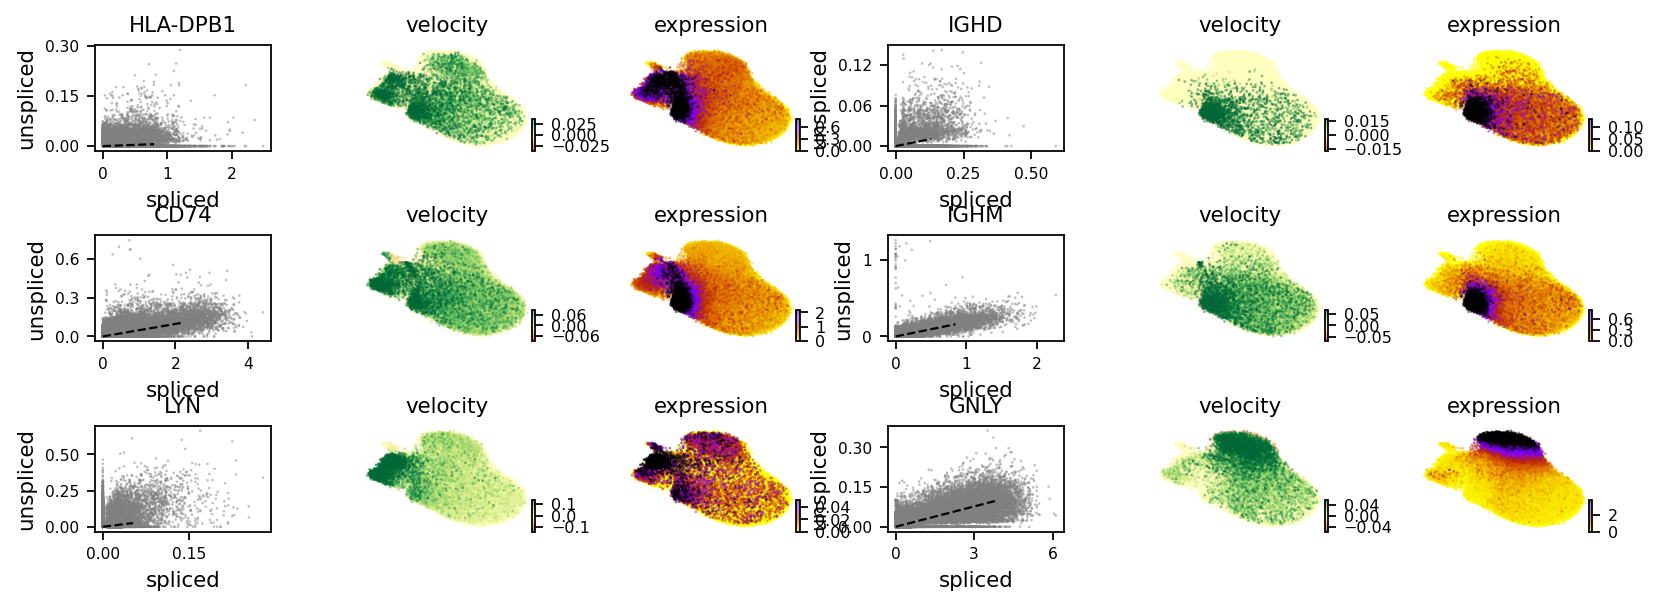

In [ ]:
scv.pl.velocity(adata, df['CD4+ T Helper2'][:6], ncols=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


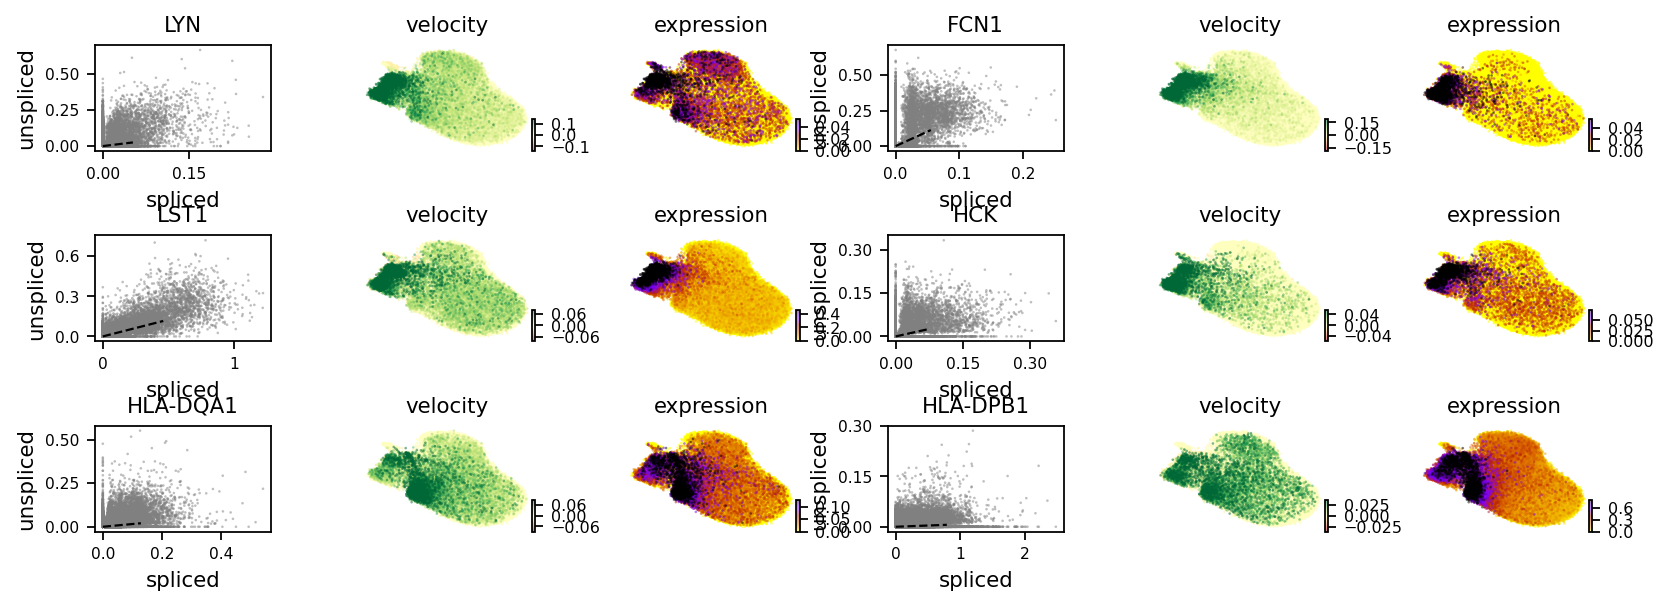

In [ ]:
scv.pl.velocity(adata, df['Dendritic'][:6], ncols=2)

### PAGA velocity graph
[PAGA](https://doi.org/10.1186/s13059-019-1663-x) graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. Here, PAGA is extended by velocity-inferred directionality.

In [ ]:
# PAGA requires to install igraph, if not done yet.
# !pip install python-igraph --upgrade --quiet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='celltype')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

computing terminal states
    identified 10 regions of root cells and 2 regions of end points .
    finished (0:01:48) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:48) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,CD4+ T Helper2,CD4+/CD25 T Reg,CD4+/CD45RA+/CD25- Naive T,CD4+/CD45RO+ Memory,CD8+ Cytotoxic T,CD8+/CD45RA+ Naive Cytotoxic,CD14+ Monocyte,CD19+ B,CD34+,CD56+ NK,Dendritic
CD4+ T Helper2,0,0,0,0,0,0.054,0,0,0,0,0
CD4+/CD25 T Reg,0,0,0,0,0,0.67,0,0,0,0,0
CD4+/CD45RA+/CD25- Naive T,0,0,0,0,0,0,0,0,0,0,0
CD4+/CD45RO+ Memory,0,0,0,0,0,0.55,0,0,0,0,0
CD8+ Cytotoxic T,0,0,0.19,0,0,0.84,0,0,0,0.48,0
CD8+/CD45RA+ Naive Cytotoxic,0,0,0,0,0,0,0,0,0,0,0
CD14+ Monocyte,0,0,0,0,0,0,0,0,0,0,0
CD19+ B,0,0,0,0,0,0.33,0,0,0,0,0
CD34+,0,0,0,0,0,0,0,0,0,0,0
CD56+ NK,0,0,0,0,0,0,0,0,0,0,0


This reads from left/row to right/column, thus e.g. assigning a confident transition from CD8+ Cytotoxic T to CD4+/CD45RA+/CD25- Naive T.

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


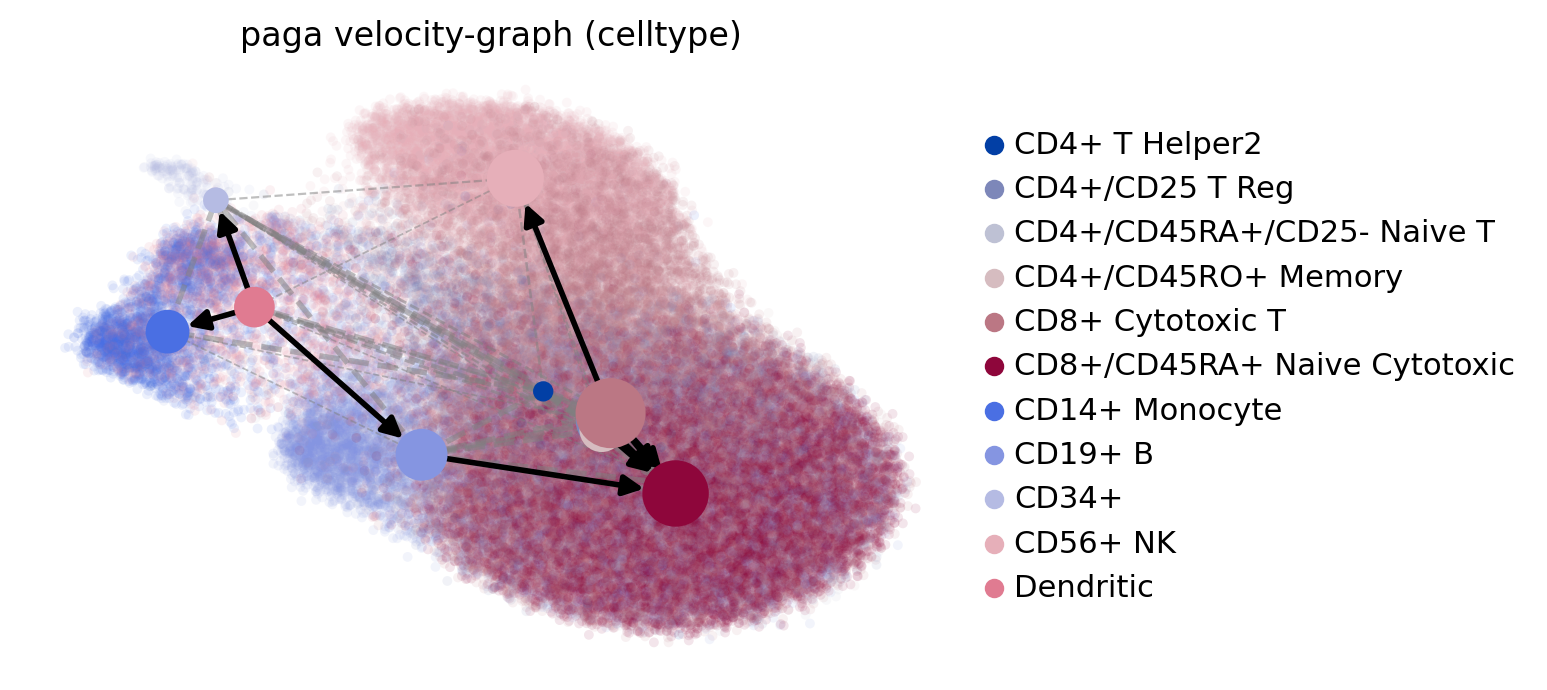

In [ ]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)